# Imports

In [1]:
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import roc_curve, auc
import numpy as np



# Set Parameters

In [2]:
lag = 180  #Lag in days in X-day while predicting Y=recession probability

# Download Relevant Data

In [3]:


url = 'https://fred.stlouisfed.org/series/USREC/downloaddata/USREC.csv'
data_recession = pd.read_csv(url)
data_recession.head()

,DATE,VALUE
0,1854-12-01,1
1,1855-01-01,0
2,1855-02-01,0
3,1855-03-01,0
4,1855-04-01,0


In [4]:
url_t10y2y = 'https://fred.stlouisfed.org/series/T10Y2Y/downloaddata/T10Y2Y.csv'
data_t10y2y = pd.read_csv(url_t10y2y)
data_t10y2y.head()

,DATE,VALUE
0,1976-06-01,0.68
1,1976-06-02,0.71
2,1976-06-03,0.70
3,1976-06-04,0.77
4,1976-06-07,0.79


In [5]:
url_t10y3m = 'https://fred.stlouisfed.org/series/T10Y3M/downloaddata/T10Y3M.csv'
data_t10y3m = pd.read_csv(url_t10y3m)
data_t10y3m.head()

,DATE,VALUE
0,1982-01-04,2.32
1,1982-01-05,2.24
2,1982-01-06,2.43
3,1982-01-07,2.46
4,1982-01-08,2.50


In [6]:
# Fetch SPX data with maximum history
spx_data = yf.download('^GSPC', period='max')
spx_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,0
1928-01-03,17.760000,17.760000,17.760000,17.760000,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,0
1928-01-06,17.660000,17.660000,17.660000,17.660000,0


In [7]:
vix_data = yf.download('^VIX', period='max')
vix_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^VIX,^VIX,^VIX,^VIX,^VIX
Date,,,,,
1990-01-02,17.240000,17.240000,17.240000,17.240000,0
1990-01-03,18.190001,18.190001,18.190001,18.190001,0
1990-01-04,19.219999,19.219999,19.219999,19.219999,0
1990-01-05,20.110001,20.110001,20.110001,20.110001,0
1990-01-08,20.260000,20.260000,20.260000,20.260000,0


In [8]:
# Convert DATE column to datetime type
data_recession['DATE'] = pd.to_datetime(data_recession['DATE'])

# Set DATE as the index
data_recession.set_index('DATE', inplace=True)

# Resample the data from monthly to daily, forward filling the values
data_recession_daily = data_recession.resample('D').ffill()

# Extend the last month's data by an additional 2 months
last_date = data_recession_daily.index[-1]
extended_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=61, freq='D')
extended_data = pd.DataFrame(index=extended_dates, columns=data_recession_daily.columns)
extended_data['VALUE'] = data_recession_daily.iloc[-1]['VALUE']

# Append the extended data to the original dataframe
data_recession_daily = pd.concat([data_recession_daily, extended_data])

# Rename the index column to lowercase 'date'
data_recession_daily.rename_axis('date', inplace=True)
data_recession_daily.rename(columns={'VALUE': 'USREC'}, inplace=True)
data_recession_daily.tail(70)# Display the last 70 rows to verify the extension

,USREC
date,
2024-10-24,0
2024-10-25,0
2024-10-26,0
2024-10-27,0
2024-10-28,0
...,...
2024-12-28,0
2024-12-29,0
2024-12-30,0


# Clean Data

In [9]:
# Keep only the 'Date' and 'Close' columns for SPX and VIX dataframes
spx_data = spx_data[['Close']]
vix_data = vix_data[['Close']]

# Convert 'Date' column to datetime and set it as the index
spx_data.index = pd.to_datetime(spx_data.index)
vix_data.index = pd.to_datetime(vix_data.index)

# Rename the index to lowercase 'date'
spx_data.index.name = 'date'
vix_data.index.name = 'date'

# Rename the 'Close' columns to 'SPX' and 'VIX' respectively
spx_data.rename(columns={'Close': 'SPX'}, inplace=True)
vix_data.rename(columns={'Close': 'VIX'}, inplace=True)

# Display the first few rows to verify the changes
#spx_data.head(), vix_data.head()
# Remove multi-index and keep only the 'SPX' column
spx_data.columns = spx_data.columns.droplevel(1)
spx_data.columns = ['SPX']

# Display the first few rows to verify the changes
spx_data.head()

# Remove multi-index and keep only the 'VIX' column
vix_data.columns = vix_data.columns.droplevel(1)
vix_data.columns = ['VIX']


In [10]:
# Convert DATE column to datetime type and rename it to 'date'
data_t10y2y['DATE'] = pd.to_datetime(data_t10y2y['DATE'])
data_t10y2y.rename(columns={'DATE': 'date'}, inplace=True)
data_t10y2y.set_index('date', inplace=True)

data_t10y3m['DATE'] = pd.to_datetime(data_t10y3m['DATE'])
data_t10y3m.rename(columns={'DATE': 'date'}, inplace=True)
data_t10y3m.set_index('date', inplace=True)

# Display the first few rows to verify the changes
data_t10y2y.head(), data_t10y3m.head()

data_t10y2y.columns = ['T10Y2Y']
data_t10y3m.columns = ['T10Y3M']

  


In [11]:
data_t10y2y['T10Y2Y']= pd.to_numeric(data_t10y2y['T10Y2Y'], errors='coerce')
data_t10y3m['T10Y3M']=pd.to_numeric(data_t10y3m['T10Y3M'], errors='coerce')
data_t10y2y.dropna(inplace=True)
data_t10y3m.dropna(inplace=True)

In [12]:
# Merge all data frames by index 'date' and drop NaN values
df = pd.concat([data_recession_daily, data_t10y2y, data_t10y3m, spx_data, vix_data], axis=1).dropna()

# Display the first few rows to verify the merge
df.head()

,USREC,T10Y2Y,T10Y3M,SPX,VIX
date,,,,,
1990-01-02,0,0.07,0.11,359.690002,17.240000
1990-01-03,0,0.05,0.10,358.760010,18.190001
1990-01-04,0,0.06,0.14,355.670013,19.219999
1990-01-05,0,0.09,0.20,352.200012,20.110001
1990-01-08,0,0.12,0.23,353.790009,20.260000


In [13]:
df.tail()


,USREC,T10Y2Y,T10Y3M,SPX,VIX
date,,,,,
2024-12-20,0,0.22,0.18,5930.850098,18.360001
2024-12-23,0,0.29,0.23,5974.069824,16.780001
2024-12-24,0,0.30,0.19,6040.040039,14.270000
2024-12-26,0,0.28,0.23,6037.589844,14.730000
2024-12-27,0,0.31,0.31,5970.839844,15.950000


# Explore the recession data

In [14]:
df['USREC'].value_counts()/len(df)

USREC
0    0.914665
1    0.085335
Name: count, dtype: float64

In [15]:
# Separate the X and Y variables
X = df.drop(columns=['USREC'])
y = df['USREC']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the X variables
X_scaled = scaler.fit_transform(X)

# Convert the scaled X variables back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

# Combine the scaled X variables with the Y variable
df_scaled = pd.concat([X_scaled_df, y], axis=1)

# Display the first few rows to verify the changes


In [16]:
df_scaled.tail()

,T10Y2Y,T10Y3M,SPX,VIX,USREC
date,,,,,
2024-12-20,-0.869698,-1.033486,3.389652,-0.140405,0
2024-12-23,-0.793933,-0.994331,3.424228,-0.342232,0
2024-12-24,-0.783110,-1.025655,3.477005,-0.662857,0
2024-12-26,-0.804757,-0.994331,3.475045,-0.604097,0
2024-12-27,-0.772286,-0.931683,3.421644,-0.448256,0


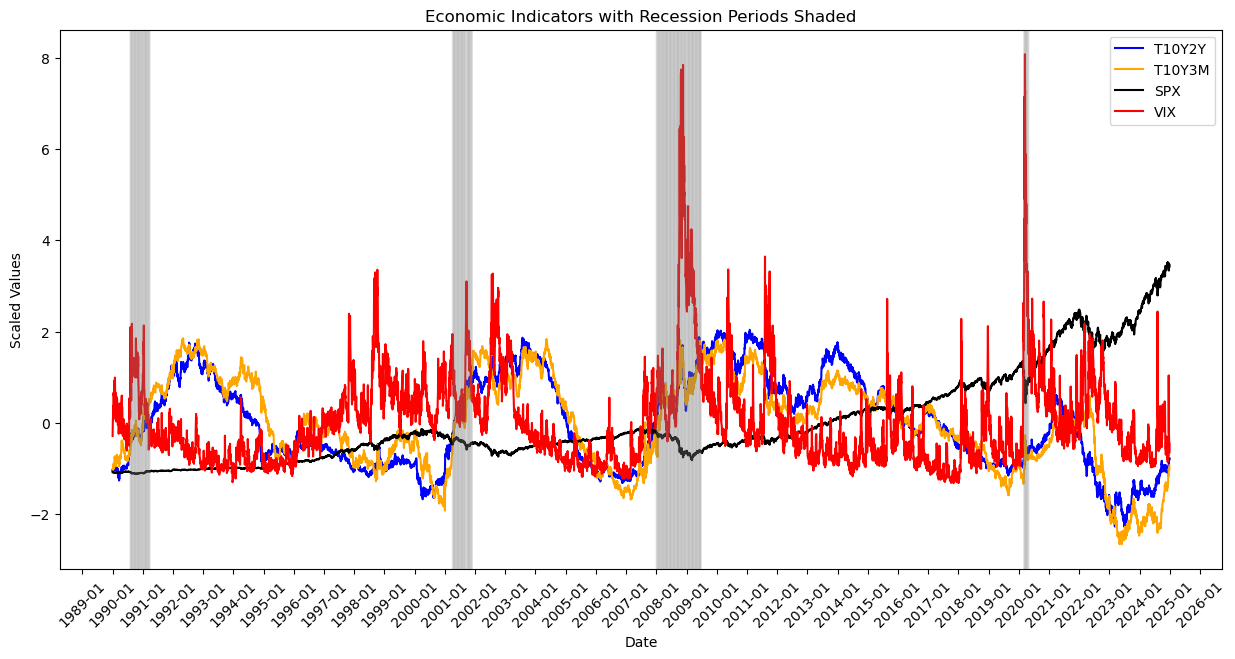

In [17]:
# Set the figure size
plt.figure(figsize=(15, 7))

# Define colors for each column
colors = {'SPX': 'black', 'VIX': 'red', 'T10Y2Y': 'blue', 'T10Y3M': 'orange'}

# Plot the lines for each column in df_scaled except USREC
for column in df_scaled.columns[:-1]:
    sns.lineplot(data=df_scaled, x=df_scaled.index, y=column, label=column, color=colors[column])

# Shade the areas where USREC is 1 with lower alpha for transparency
recession_periods = df_scaled[df_scaled['USREC'] == 1].index
for period in recession_periods:
    plt.axvline(x=period, color='gray', alpha=0.03)  # Adjust alpha for transparency

# Set the labels and title
plt.xlabel('Date')
plt.ylabel('Scaled Values')
plt.title('Economic Indicators with Recession Periods Shaded')
plt.legend()

# Set x-axis major locator to month and formatter to show month and year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Draw gridlines
#plt.grid(True)

plt.show()


In [18]:

XdfScaledLagged=X_scaled_df.shift(periods=lag,freq='D') # 6 months lag
XYdf = pd.concat([y,XdfScaledLagged],axis=1,join='inner')
display(XYdf.head())
display(XYdf.tail())
# When a 6 month lag is applied to the data, the first 6 months of data will be removed, 
# some dates at the end may not align with orignal dates as T+6 months may not be a valid date or a holiday moved forward

,USREC,T10Y2Y,T10Y3M,SPX,VIX
date,,,,,
1990-07-02,0,-1.053699,-1.096135,-1.068060,-0.162121
1990-07-03,0,-1.042875,-1.064810,-1.070532,-0.030550
1990-07-09,0,-0.977934,-0.955176,-1.077220,0.380769
1990-07-10,0,-0.967110,-0.986500,-1.076244,0.075473
1990-07-11,0,-0.923816,-0.892528,-1.083124,0.661795


,USREC,T10Y2Y,T10Y3M,SPX,VIX
date,,,,,
2024-12-11,0,-1.616524,-2.200311,2.990249,-0.868516
2024-12-17,0,-1.594877,-2.153324,3.023505,-0.789318
2024-12-18,0,-1.594877,-2.145493,3.016665,-0.799537
2024-12-23,0,-1.529936,-2.098507,3.027289,-0.882568
2024-12-24,0,-1.551583,-2.114169,3.031265,-0.922167


In [19]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3,random_state=42)
for train_indx,test_indx in split.split(XYdf,XYdf['USREC']):
    strat_train_set = XYdf.iloc[train_indx]
    strat_test_set = XYdf.iloc[test_indx]

In [20]:
print(strat_train_set['USREC'].value_counts()/len(strat_train_set)) #Check recession days split in training data
print(strat_test_set['USREC'].value_counts()/len(strat_test_set)) #Check recession days split in testing data

USREC
0    0.912732
1    0.087268
Name: count, dtype: float64
USREC
0    0.912608
1    0.087392
Name: count, dtype: float64


In [21]:
LR = LogisticRegression(class_weight='balanced')
Xtrain = strat_train_set.loc[:,strat_train_set.columns!='USREC'].values
Ytrain = strat_train_set.loc[:,strat_train_set.columns=='USREC'].values.ravel()

Xtest = strat_test_set.loc[:,strat_test_set.columns!='USREC'].values
Ytest = strat_test_set.loc[:,strat_test_set.columns=='USREC'].values.ravel()

LR.fit(Xtrain,Ytrain)
Ypred = LR.predict(Xtest)
print("Accuracy of classifier on test set:{:.2f}\n\n".format(LR.score(Xtest,Ytest)))
print(classification_report(Ytest,Ypred))

Accuracy of classifier on test set:0.76


              precision    recall  f1-score   support

           0       0.97      0.76      0.85      1368
           1       0.22      0.73      0.34       131

    accuracy                           0.76      1499
   macro avg       0.60      0.74      0.60      1499
weighted avg       0.90      0.76      0.81      1499



# Plot the probability of recession

In [22]:
XlaggedFullArray = XdfScaledLagged.values
recessionProbability = LR.predict_proba(XlaggedFullArray)[:,1]
probDf = pd.DataFrame(recessionProbability,columns=['RecProb'],index=XdfScaledLagged.index)
probDf['ewma'] = probDf['RecProb'].ewm(com=9.5).mean() #20-day EWMA, 
probDf.tail()

,RecProb,ewma
date,,
2025-06-18,0.026576,0.033840
2025-06-21,0.021832,0.032696
2025-06-22,0.017283,0.031228
2025-06-24,0.016591,0.029834
2025-06-25,0.018108,0.028717


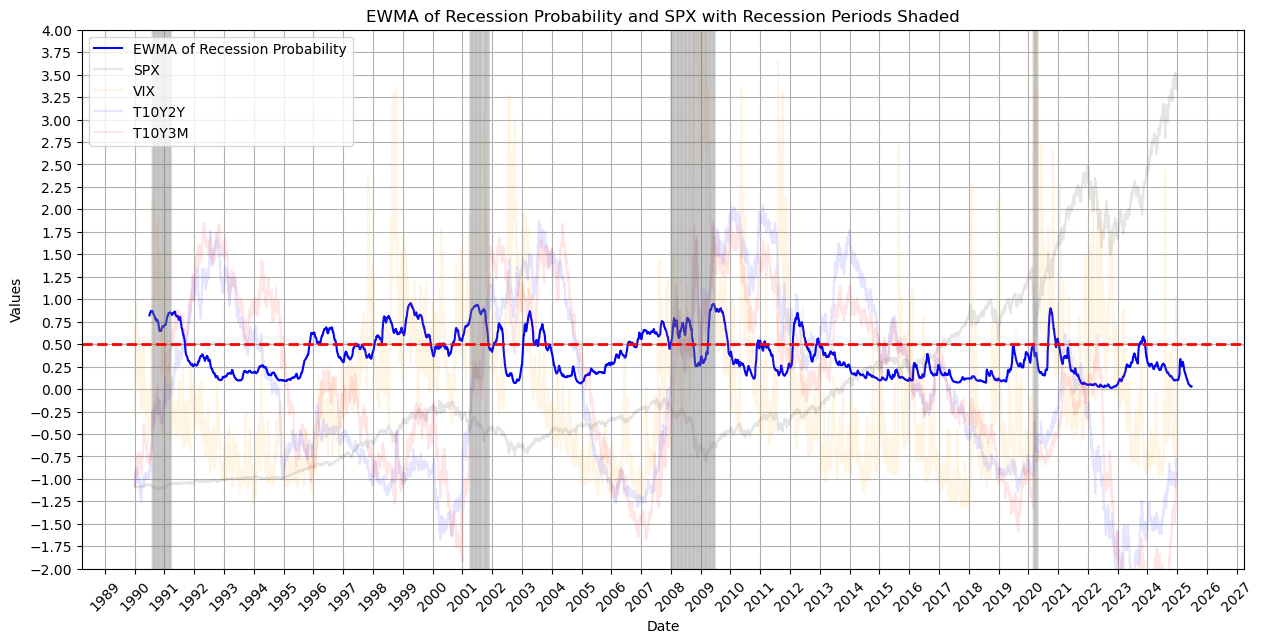

In [23]:
# Set the figure size
plt.figure(figsize=(15, 7))

# Plot the ewma column from probDf
sns.lineplot(data=probDf, x=probDf.index, y='ewma', label='EWMA of Recession Probability', color='blue')

# Overlay the SPX data from X_scaled_df
sns.lineplot(data=X_scaled_df, x=X_scaled_df.index, y='SPX', label='SPX', color='black', alpha=0.1)
sns.lineplot(data=X_scaled_df, x=X_scaled_df.index, y='VIX', label='VIX', color='orange', alpha=0.1)
sns.lineplot(data=X_scaled_df, x=X_scaled_df.index, y='T10Y2Y', label='T10Y2Y', color='blue', alpha=0.1)
sns.lineplot(data=X_scaled_df, x=X_scaled_df.index, y='T10Y3M', label='T10Y3M', color='red', alpha=0.1)

# Shade the areas where USREC is 1 with lower alpha for transparency
recession_periods = df_scaled[df_scaled['USREC'] == 1].index
for period in recession_periods:
    plt.axvline(x=period, color='gray', alpha=0.03)  # Adjust alpha for transparency

# Add a bold horizontal line at y=0.5
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=2)

# Set the labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('EWMA of Recession Probability and SPX with Recession Periods Shaded')
plt.legend()

# Set x-axis major locator to year and formatter to show year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set y-axis limits to make the scale look wider
plt.ylim(-2, 4)

# Set y-axis ticks to be at intervals of 0.25
plt.yticks(np.arange(-2, 4.25, 0.25))

# Draw gridlines
plt.grid(True)

plt.show()


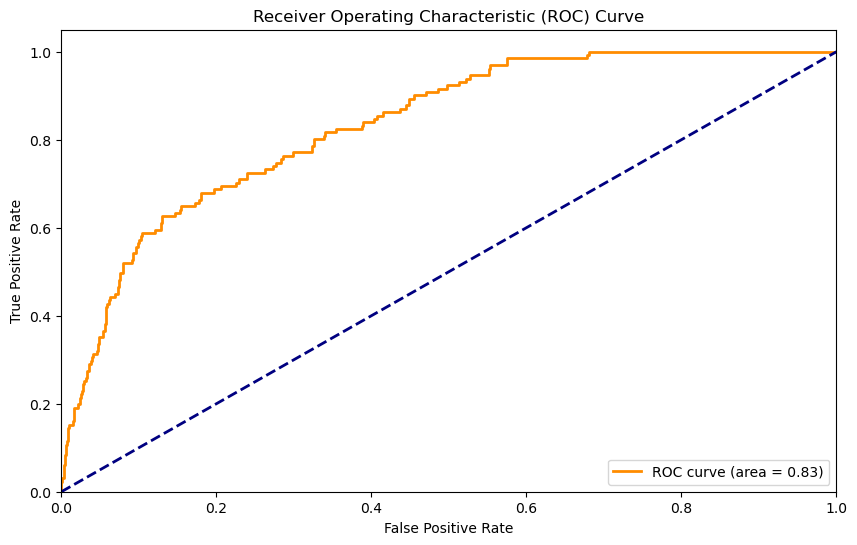

In [24]:


# Predict probabilities for the test set
Ytest_prob = LR.predict_proba(Xtest)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(Ytest, Ytest_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [25]:
# Add a predict column to probDf using the LR model and XlaggedFullArray
probDf['predict'] = LR.predict(XlaggedFullArray)
probDf[probDf['predict'] == 1].tail(10)

,RecProb,ewma,predict
date,,,
2023-11-13,0.534621,0.579240,1
2023-11-18,0.525121,0.557354,1
2023-11-19,0.555788,0.557205,1
2023-11-20,0.594146,0.560723,1
2023-11-26,0.544073,0.543341,1
2023-11-27,0.573227,0.546187,1
2023-11-28,0.522003,0.543884,1
2025-02-01,0.843314,0.256807,1
2025-02-02,0.583854,0.287954,1
